# Pylops - seismic inversion

### Author: M.Ravasi

In this notebook I will go through three inverse problems in seismic reservoir charactherization:

- post-stack inversion (for Acoustic Impedence)
- least-squares based wavelet estimation
- pre-stack or AVO inversion

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

import numpy as np
import matplotlib.pyplot as plt
import scipy as sp

from scipy.sparse import csr_matrix, vstack
from scipy.linalg import lstsq, solve
from scipy.sparse.linalg import LinearOperator, cg, lsqr
from scipy.signal import filtfilt

from pylops.utils                      import dottest
from pylops.utils.wavelets             import *
from pylops.utils.seismicevents        import *
from pylops.basicoperators             import *
from pylops.signalprocessing           import *
from pylops.waveeqprocessing.mdd       import *
from pylops.avo.avo                    import *
from pylops.avo.poststack              import *
from pylops.avo.prestack               import *
from pylops.optimization.leastsquares  import *

## Pre-stack modelling

Let's start considering a single interface and compute the reflection coefficient using various approximations of the Zoeppritz equation

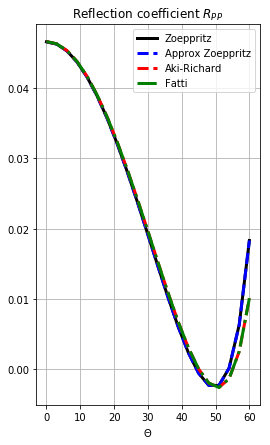

In [2]:
vp1, vs1, rho1 = 2200., 1300., 2000  # upper medium
vp0, vs0, rho0 = 2300., 1400., 2100  # lower medium

ntheta = 21
thetamin, thetamax = 0, 60
theta = np.linspace(thetamin, thetamax, ntheta)

# Create composite parameters
ai0, si0, vpvs0 = vp0*rho0, vs0*rho0, vp0/vs0
ai1, si1, vpvs1 = vp1*rho1, vs1*rho1, vp1/vs1

# Zoeppritz
rpp_zoep = zoeppritz_pp(vp1, vs1, rho1, vp0, vs0, rho0,  theta)
rpp_zoep_approx = approx_zoeppritz_pp(vp1, vs1, rho1, vp0, vs0, rho0,  theta)


# Aki Richards
rvp = np.log(vp0) - np.log(vp1)
rvs = np.log(vs0) - np.log(vs1)
rrho = np.log(rho0) - np.log(rho1)

G1, G2, G3 = akirichards(theta, vs1/vp1)
rpp_aki = G1*rvp + G2*rvs + G3*rrho

# Fatti
rai = np.log(ai0) - np.log(ai1)
rsi = np.log(si0) - np.log(si1)

G1, G2, G3 = fatti(theta, vs1/vp1)
rpp_fatti = G1*rai + G2*rsi + G3*rrho

plt.figure(figsize=(4,7))
plt.plot(theta, rpp_zoep, 'k', lw=3, label='Zoeppritz')
plt.plot(theta, rpp_zoep_approx, '--b', lw=3, label='Approx Zoeppritz')
plt.plot(theta, rpp_aki, '--r', lw=3, label='Aki-Richard')
plt.plot(theta, rpp_fatti, '-.g', lw=3, label='Fatti')
plt.xlabel(r'$\Theta$')
plt.title(r'Reflection coefficient $R_{PP}$')
plt.grid()
plt.legend();

## Pre-stack inversion - 1D

Create velocity and density profiles

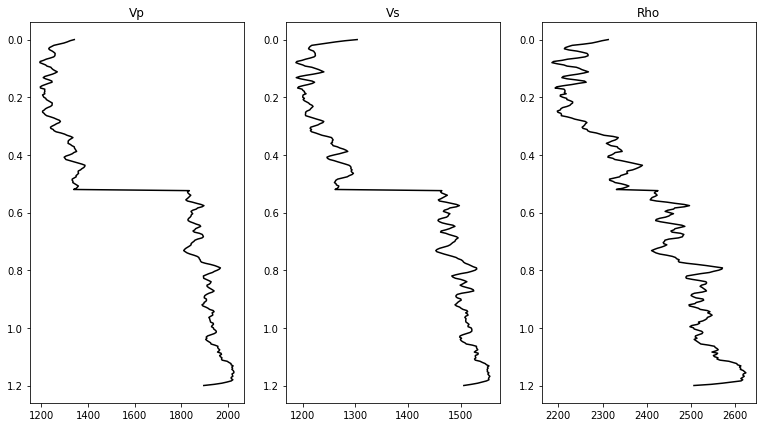

In [3]:
np.random.seed(0)

nt0 = 301
dt0 = 0.004

t0  = np.arange(nt0)*dt0
vp  = 1200 + np.arange(nt0) + filtfilt(np.ones(5)/5.,1,np.random.normal(0, 80, nt0))
vs  = 600  + vp/2           + filtfilt(np.ones(5)/5.,1,np.random.normal(0, 20, nt0))
rho = 1000 + vp             + filtfilt(np.ones(5)/5.,1,np.random.normal(0, 30, nt0))
vp[131:]+=500
vs[131:]+=200
rho[131:]+=100

fig, axs = plt.subplots (1, 3, figsize=(13,7))
axs[0].plot(vp,  t0, 'k')
axs[0].set_title('Vp')
axs[0].invert_yaxis()
axs[1].plot(vs,  t0, 'k')
axs[1].set_title('Vs')
axs[1].invert_yaxis()
axs[2].plot(rho, t0, 'k')
axs[2].set_title('Rho')
axs[2].invert_yaxis()

Define angles, wavelet and background VS/VP

In [4]:
ntheta = 21
thetamin, thetamax = 0, 40
theta = np.linspace(thetamin, thetamax, ntheta)

ntwav = 41
wav = ricker(t0[:ntwav//2+1], 15)[0]

vsvp   = 0.5
vsvp_z = np.linspace(0.4, 0.6, nt0)

m = np.stack((np.log(vp), np.log(vs), np.log(rho)),axis=1)

Create linear pre-stack modelling operator

In [5]:
# lop (constant vsvp)
PPop = PrestackLinearModelling(wav, theta, vsvp=vsvp, nt0=nt0, linearization='akirich')
dottest(PPop, nt0*ntheta, nt0*3, verb=True)

# dense (constant vsvp)
PPop_dense = PrestackLinearModelling(wav, theta, vsvp=vsvp, nt0=nt0, linearization='akirich', explicit=True)
dottest(PPop_dense, nt0*ntheta, nt0*3, verb=True);

# lop (depth-variant vsvp)
#PPop = PrestackLinearModelling(wav, theta, vsvp=vsvp_z, linearization='akirich')
#dottest(PPop, nt0*ntheta, nt0*3, verb=True)

# dense (depth-variant vsvp)
#PPop_dense = PrestackLinearModelling(wav, theta, vsvp=vsvp_z, linearization='akirich', explicit=True)
#dottest(PPop_dense, nt0*ntheta, nt0*3, verb=True);

Dot test passed, v^T(Opu)=-30.673900 - u^T(Op^Tv)=-30.673900
Dot test passed, v^T(Opu)=27.250170 - u^T(Op^Tv)=27.250170


Create data

In [6]:
# lop
dPP = PPop*m.flatten()
dPP = dPP.reshape(nt0,ntheta)

# dense
dPP_dense = PPop_dense*m.T.flatten()
dPP_dense = dPP_dense.reshape(ntheta,nt0).T
dPPn_dense = dPP_dense + np.random.normal(0, 1e-2, dPP_dense.shape)

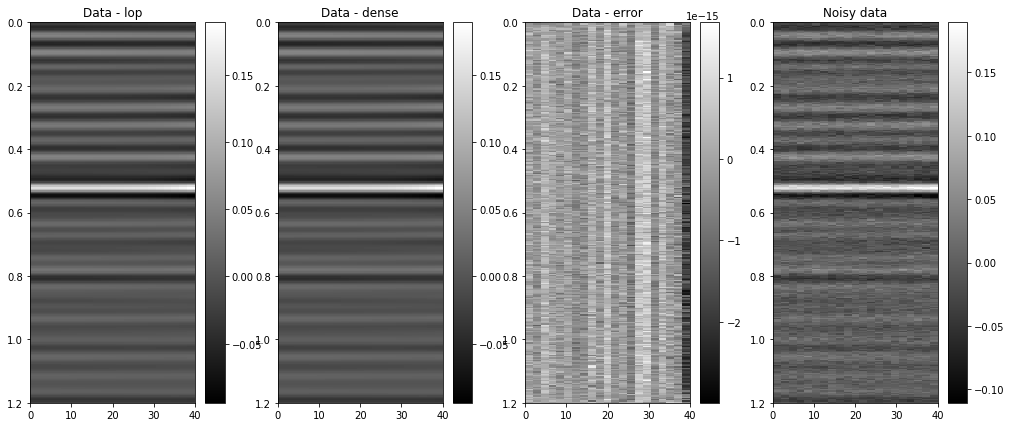

In [7]:
fig, axs = plt.subplots(1, 4, figsize=(17,7))
im = axs[0].imshow(dPP, cmap='gray', 
              extent=(theta[0], theta[-1], t0[-1], t0[0]))
axs[0].set_title('Data - lop');
axs[0].axis('tight');
fig.colorbar(im, ax=axs[0])
im = axs[1].imshow(dPP_dense, cmap='gray', 
              extent=(theta[0], theta[-1], t0[-1], t0[0]))
axs[1].set_title('Data - dense');
axs[1].axis('tight');
fig.colorbar(im, ax=axs[1])
im = axs[2].imshow(dPP - dPP_dense, cmap='gray', 
              extent=(theta[0], theta[-1], t0[-1], t0[0]))
axs[2].set_title('Data - error');
axs[2].axis('tight');
fig.colorbar(im, ax=axs[2]);
im = axs[3].imshow(dPPn_dense, cmap='gray', 
              extent=(theta[0], theta[-1], t0[-1], t0[0]))
axs[3].set_title('Noisy data');
axs[3].axis('tight');
fig.colorbar(im, ax=axs[3]);

Create background model and invert back for model

In [8]:
nsmooth = 50
mback = filtfilt(np.ones(nsmooth)/float(nsmooth), 1, m, axis=0)

# lop
dPP_0 = PPop*mback.flatten()
dPP_r = dPP.flatten() - dPP_0

minv = NormalEquationsInversion(PPop, [], dPP_r, epsI=0, **dict(maxiter=100))
minv = minv.reshape(nt0,3)

# dense
dPP_0_dense = PPop_dense*mback.T.flatten()
dPP_r_dense = dPP_dense.T.flatten() - dPP_0_dense 

minv_dense = lstsq(PPop_dense.A, dPP_r_dense, cond=1e-5)[0]
minv_dense = minv_dense.reshape(3, nt0).T

minv = mback+minv
minv_dense = mback+minv_dense

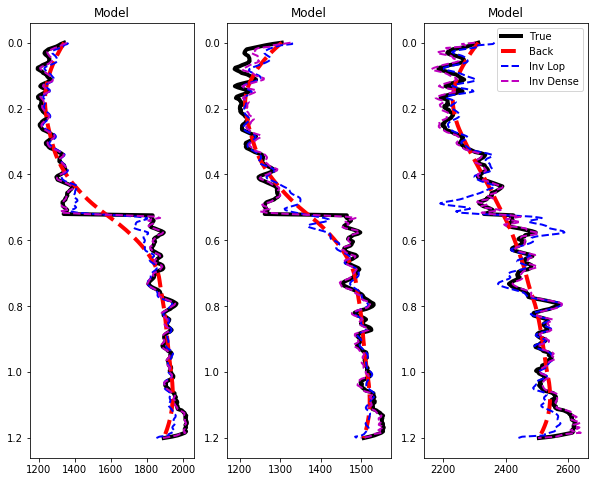

In [9]:
fig, axs = plt.subplots(1, 3, figsize=(10, 8))
axs[0].plot(vp, t0, 'k', lw=4, label='True')
axs[0].plot(np.exp(mback[:, 0]), t0, '--r', lw=4, label='Back')
axs[0].plot(np.exp(minv[:, 0]), t0, '--b', lw=2, label='Inv Lop')
axs[0].plot(np.exp(minv_dense[:, 0]), t0, '--m', lw=2, label='Inv Dense')
axs[0].set_title('Model')
axs[0].invert_yaxis()
axs[1].plot(vs, t0, 'k', lw=4, label='True')
axs[1].plot(np.exp(mback[:, 1]), t0, '--r', lw=4, label='Back')
axs[1].plot(np.exp(minv[:, 1]), t0, '--b', lw=2, label='Inv Lop')
axs[1].plot(np.exp(minv_dense[:, 1]), t0, '--m', lw=2, label='Inv Dense')
#axs[1].plot(np.exp(minv_noise[:, 1]), t0, '--g', lw=2, label='Inv Noisy')
axs[1].set_title('Model')
axs[1].invert_yaxis()
axs[1].axis('tight')
axs[2].plot(rho, t0, 'k', lw=4, label='True')
axs[2].plot(np.exp(mback[:, 2]), t0, '--r', lw=4, label='Back')
axs[2].plot(np.exp(minv[:, 2]), t0, '--b', lw=2, label='Inv Lop')
axs[2].plot(np.exp(minv_dense[:, 2]), t0, '--m', lw=2, label='Inv Dense')
#axs[2].plot(np.exp(minv_noise[:, 2]), t0, '--g', lw=2, label='Inv Noisy')
axs[2].set_title('Model')
axs[2].invert_yaxis()
axs[2].axis('tight')
axs[2].legend();

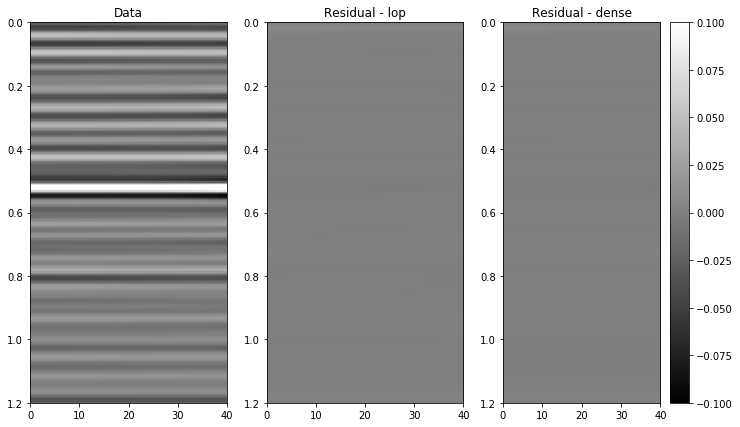

In [10]:
fig, axs = plt.subplots(1, 3, figsize=(12,7))
im = axs[0].imshow(dPP, cmap='gray', 
              extent=(theta[0], theta[-1], t0[-1], t0[0]), vmin=-0.1, vmax=0.1)
axs[0].set_title('Data');
axs[0].axis('tight');
im = axs[1].imshow(dPP - (PPop*(mback + minv).flatten()).reshape(nt0,ntheta), cmap='gray', 
              extent=(theta[0], theta[-1], t0[-1], t0[0]), vmin=-0.1, vmax=0.1)
axs[1].set_title('Residual - lop');
axs[1].axis('tight');
im = axs[2].imshow(dPP_dense - (PPop_dense*(mback + minv_dense).T.flatten()).reshape(ntheta,nt0).T, cmap='gray', 
              extent=(theta[0], theta[-1], t0[-1], t0[0]), vmin=-0.1, vmax=0.1)
axs[2].set_title('Residual - dense');
axs[2].axis('tight');
fig.colorbar(im, ax=axs[2]);

Let's use the function

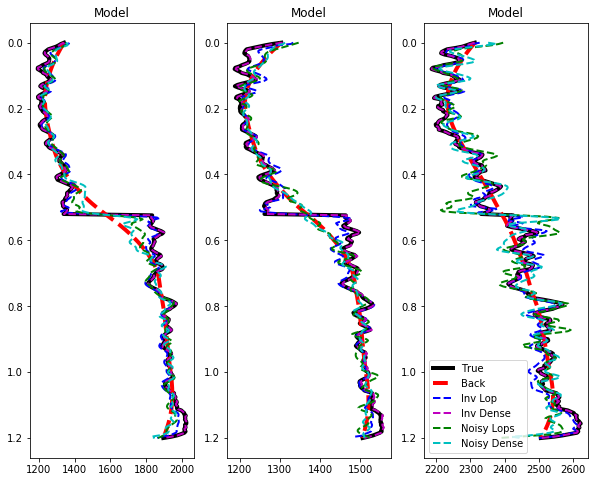

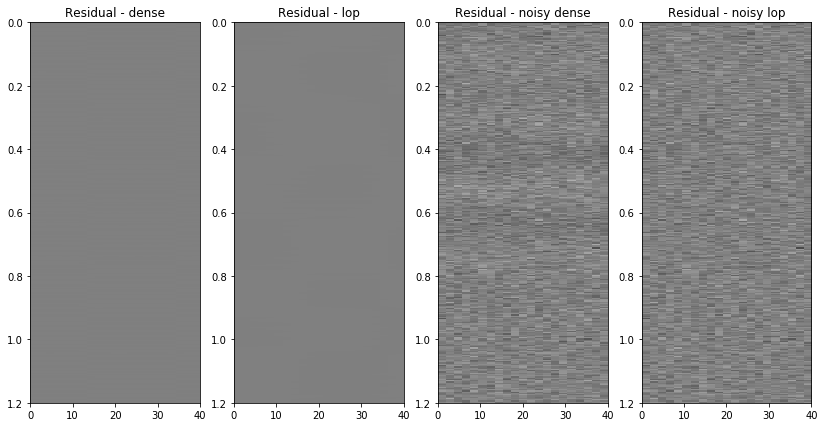

In [11]:
minv_dense, dPP_dense_res = \
    PrestackInversion(dPP_dense, theta, wav, m0=mback, linearization='akirich',
                      explicit=True, returnres=True, **dict(cond=1e-10))

minv, dPP_res = \
    PrestackInversion(dPP, theta, wav, m0=mback, linearization='akirich',
                      explicit=False, returnres=True, **dict(damp=1e-10, iter_lim=2000))

minv_dense_noise, dPPn_dense_res = \
    PrestackInversion(dPPn_dense, theta, wav, m0=mback, linearization='akirich', explicit=True, 
                      simultaneous=False, returnres=True, **dict(cond=1e-1))

minv_noise, dPPn_res = \
    PrestackInversion(dPPn_dense, theta, wav, m0=mback, linearization='akirich', explicit=False, 
                      epsR=5e-1,
                      returnres=True, **dict(damp=1e-1, iter_lim=100))

fig, axs = plt.subplots(1, 3, figsize=(10, 8))
axs[0].plot(vp, t0, 'k', lw=4, label='True')
axs[0].plot(np.exp(mback[:, 0]), t0, '--r', lw=4, label='Back')
axs[0].plot(np.exp(minv[:, 0]), t0, '--b', lw=2, label='Inv Lop')
axs[0].plot(np.exp(minv_dense[:, 0]), t0, '--m', lw=2, label='Inv Dense')
axs[0].plot(np.exp(minv_noise[:, 0]), t0, '--g', lw=2, label='Noisy Lops')
axs[0].plot(np.exp(minv_dense_noise[:, 0]), t0, '--c', lw=2, label='Noisy Dense')
axs[0].set_title('Model')
axs[0].invert_yaxis()
axs[0].axis('tight')
axs[1].plot(vs, t0, 'k', lw=4, label='True')
axs[1].plot(np.exp(mback[:, 1]), t0, '--r', lw=4, label='Back')
axs[1].plot(np.exp(minv[:, 1]), t0, '--b', lw=2, label='Inv Lop')
axs[1].plot(np.exp(minv_dense[:, 1]), t0, '--m', lw=2, label='Inv Dense')
axs[1].plot(np.exp(minv_noise[:, 1]), t0, '--g', lw=2, label='Noisy Lops')
axs[1].plot(np.exp(minv_dense_noise[:, 1]), t0, '--c', lw=2, label='Noisy Dense')
axs[1].set_title('Model')
axs[1].invert_yaxis()
axs[1].axis('tight')
axs[2].plot(rho, t0, 'k', lw=4, label='True')
axs[2].plot(np.exp(mback[:, 2]), t0, '--r', lw=4, label='Back')
axs[2].plot(np.exp(minv[:, 2]), t0, '--b', lw=2, label='Inv Lop')
axs[2].plot(np.exp(minv_dense[:, 2]), t0, '--m', lw=2, label='Inv Dense')
axs[2].plot(np.exp(minv_noise[:, 2]), t0, '--g', lw=2, label='Noisy Lops')
axs[2].plot(np.exp(minv_dense_noise[:, 2]), t0, '--c', lw=2, label='Noisy Dense')
axs[2].set_title('Model')
axs[2].invert_yaxis()
axs[2].axis('tight')
axs[2].legend();

fig, axs = plt.subplots(1, 4, figsize=(14,7))
im = axs[0].imshow(dPP_dense_res, cmap='gray', 
              extent=(theta[0], theta[-1], t0[-1], t0[0]), vmin=-0.1, vmax=0.1)
axs[0].set_title('Residual - dense');
axs[0].axis('tight');
im = axs[1].imshow(dPP_res, cmap='gray', 
              extent=(theta[0], theta[-1], t0[-1], t0[0]), vmin=-0.1, vmax=0.1)
axs[1].set_title('Residual - lop');
axs[1].axis('tight');
im = axs[2].imshow(dPPn_dense_res, cmap='gray', 
              extent=(theta[0], theta[-1], t0[-1], t0[0]), vmin=-0.1, vmax=0.1)
axs[2].set_title('Residual - noisy dense');
axs[2].axis('tight');
im = axs[3].imshow(dPPn_res, cmap='gray', 
              extent=(theta[0], theta[-1], t0[-1], t0[0]), vmin=-0.1, vmax=0.1)
axs[3].set_title('Residual - noisy lop');
axs[3].axis('tight');

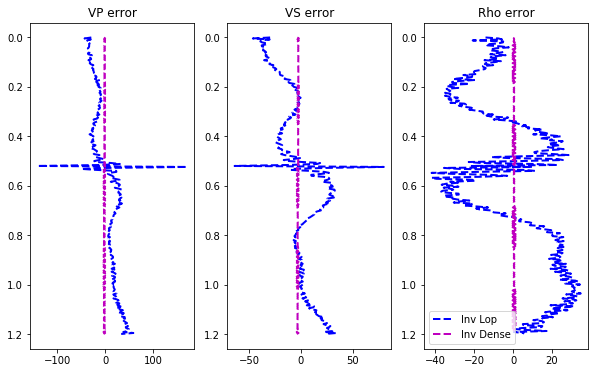

In [12]:
fig, axs = plt.subplots(1, 3, figsize=(10, 6))
axs[0].plot(vp-np.exp(minv[:, 0]), t0, '--b', lw=2, label='Inv Lop')
axs[0].plot(vp-np.exp(minv_dense[:, 0]), t0, '--m', lw=2, label='Inv Dense')
axs[0].set_title('VP error')
axs[0].invert_yaxis()
#axs[0].axis('tight')
axs[1].plot(vs-np.exp(minv[:, 1]), t0, '--b', lw=2, label='Inv Lop')
axs[1].plot(vs-np.exp(minv_dense[:, 1]), t0, '--m', lw=2, label='Inv Dense')
axs[1].set_title('VS error')
axs[1].invert_yaxis()
#axs[1].axis('tight')
axs[2].plot(rho-np.exp(minv[:, 2]), t0, '--b', lw=2, label='Inv Lop')
axs[2].plot(rho-np.exp(minv_dense[:, 2]), t0, '--m', lw=2, label='Inv Dense')
axs[2].set_title('Rho error')
axs[2].invert_yaxis()
#axs[2].axis('tight')
axs[2].legend();

## Least-squares wavelet estimation

Dot test passed, v^T(Opu)=2.623186 - u^T(Op^Tv)=2.623186
Dot test passed, v^T(Opu)=-3.826961 - u^T(Op^Tv)=-3.826961


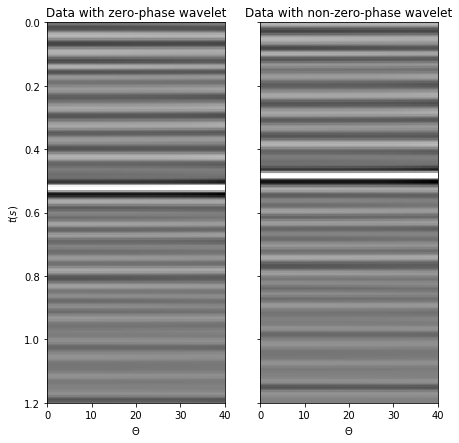

In [13]:
# Create wavelets
ntwav = 41
wavoff=10
wav, twav, wavc = ricker(t0[:ntwav//2+1],20)
wav_phase = np.hstack((wav[wavoff:], np.zeros(wavoff)))

# Create operators
Wavesop = PrestackWaveletModelling(m, theta, nwav=ntwav, wavc=wavc,
                                    vsvp=vsvp, linearization='akirich')
Wavesop_phase = PrestackWaveletModelling(m, theta, nwav=ntwav, wavc=wavc,
                                          vsvp=vsvp, linearization='akirich')
dottest(Wavesop, nt0*ntheta, ntwav, verb=True);
dottest(Wavesop_phase, nt0*ntheta, ntwav, verb=True);

# Create data
d = (Wavesop*wav).reshape(ntheta,nt0).T
d_phase = (Wavesop_phase*wav_phase).reshape(ntheta,nt0).T

fig, axs = plt.subplots(1,2, figsize=(7,7), sharey=True)
axs[0].imshow(d, cmap='gray', 
              extent=(theta[0], theta[-1], t0[-1], t0[0]), vmin=-0.1, vmax=0.1)
axs[0].axis('tight')
axs[0].set_xlabel(r'$\Theta$'), axs[0].set_ylabel(r'$t(s)$')
axs[0].set_title('Data with zero-phase wavelet')
axs[1].imshow(d_phase, cmap='gray', 
              extent=(theta[0], theta[-1], t0[-1], t0[0]), vmin=-0.1, vmax=0.1)
axs[1].axis('tight')
axs[1].set_title('Data with non-zero-phase wavelet')
axs[1].set_xlabel(r'$\Theta$');

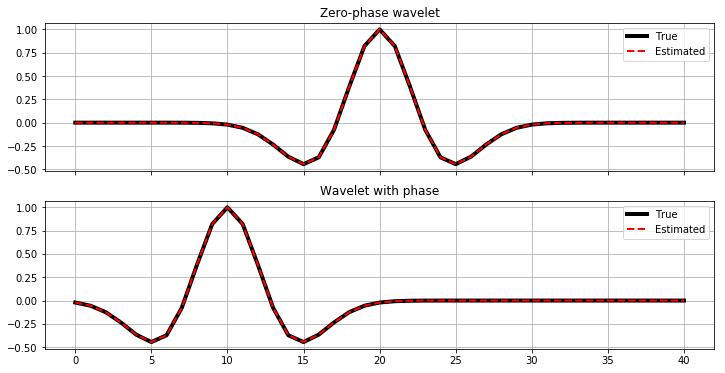

In [14]:
wav_est = Wavesop / d.T.flatten()
wav_phase_est = Wavesop_phase / d_phase.T.flatten()

fig, axs = plt.subplots(2, 1, sharex=True, figsize=(12,6))
axs[0].plot(wav, 'k', lw=4, label='True')
axs[0].plot(wav_est, '--r', lw=2, label='Estimated')
axs[0].set_title('Zero-phase wavelet')
axs[0].grid()
axs[0].legend(loc='best')
axs[0].axis('tight')
axs[1].plot(wav_phase, 'k', lw=4, label='True')
axs[1].plot(wav_phase_est, '--r', lw=2, label='Estimated')
axs[1].set_title('Wavelet with phase')
axs[1].grid()
axs[1].legend(loc='best')
axs[1].axis('tight');

Let's add some noise to the data and repeat the estimation

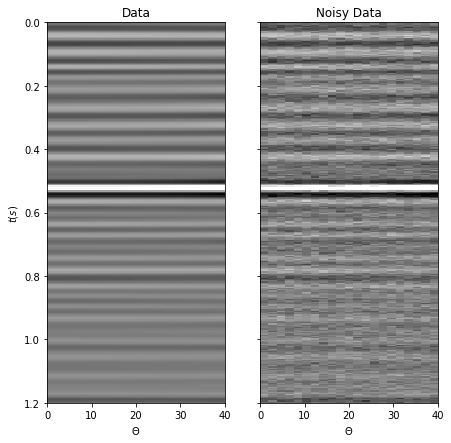

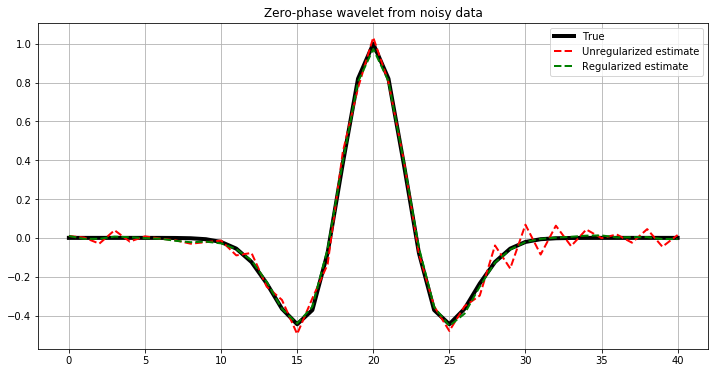

In [15]:
#add noise 
dn = d + np.random.normal(0, 1e-2, d.shape)

# unregularized estimate
wavn_est = Wavesop / dn.T.flatten()

# regularized estimate
# Create regularization operator
D2op  = SecondDerivative(ntwav, dtype='float64')

# Invert for interpolated signal
wavn_reg_est, istop, itn, r1norm, r2norm = \
    RegularizedInversion(Wavesop, [D2op], dn.T.flatten(), epsRs=[np.sqrt(0.1)], returninfo=True,
                         **dict(damp=np.sqrt(1e-4), iter_lim=200 ,show=0))

fig, axs = plt.subplots(1,2, figsize=(7,7), sharey=True)
axs[0].imshow(d, cmap='gray', 
              extent=(theta[0], theta[-1], t0[-1], t0[0]), vmin=-0.1, vmax=0.1)
axs[0].axis('tight')
axs[0].set_xlabel(r'$\Theta$'), axs[0].set_ylabel(r'$t(s)$')
axs[0].set_title('Data')
axs[1].imshow(dn, cmap='gray', 
              extent=(theta[0], theta[-1], t0[-1], t0[0]), vmin=-0.1, vmax=0.1)
axs[1].axis('tight')
axs[1].set_title('Noisy Data')
axs[1].set_xlabel(r'$\Theta$');

fig, ax = plt.subplots(1, 1, sharex=True, figsize=(12,6))
ax.plot(wav, 'k', lw=4, label='True')
ax.plot(wavn_est, '--r', lw=2, label='Unregularized estimate')
ax.plot(wavn_reg_est, '--g', lw=2, label='Regularized estimate')
ax.set_title('Zero-phase wavelet from noisy data')
ax.grid()
ax.legend(loc='best')
ax.axis('tight');

Finally we perform a preconditioned inversion and ensure symmetricity of the estimated wavelet

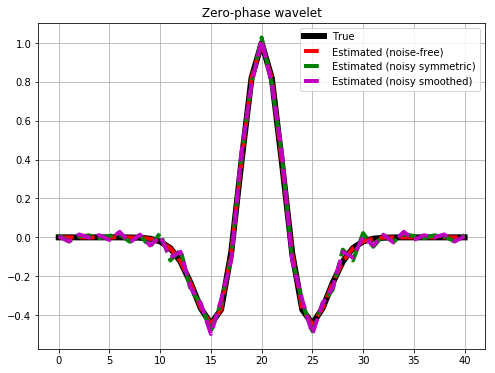

In [16]:
# Create symmetrize operator
Sop = Symmetrize((ntwav+1)//2)

# Create smoothing operator
Smop = Smoothing1D(5, dims=((ntwav+1)//2,), dtype='float64')

# Invert for interpolated signal
wavn_prec_est = \
    PreconditionedInversion(Wavesop, Sop,
                            dn.T.flatten(),
                            returninfo=False,
                            **dict(damp=np.sqrt(1e-4),
                                   iter_lim=200,show=0))

wavn_smooth_est = \
    PreconditionedInversion(Wavesop, Sop*Smop,
                            dn.T.flatten(),
                            returninfo=False,
                            **dict(damp=np.sqrt(1e-4),
                                   iter_lim=200,show=0))

fig, ax = plt.subplots(1, 1, sharex=True, figsize=(8, 6))
ax.plot(wav, 'k', lw=6, label='True')
ax.plot(wav_est, '--r', lw=4, label='Estimated (noise-free)')
ax.plot(wavn_prec_est, '--g', lw=4, label='Estimated (noisy symmetric)')
ax.plot(wavn_smooth_est, '--m', lw=4, label='Estimated (noisy smoothed)')
ax.set_title('Zero-phase wavelet')
ax.grid()
ax.legend(loc='upper right')

## Post-stack inversion - 1D

In [17]:
m1d = np.log(vp*rho).flatten()

# lop
PPop = PoststackLinearModelling(wav, nt0=nt0)
dottest(PPop, nt0, nt0, verb=True)

# dense
PPop_dense = PoststackLinearModelling(wav, nt0=nt0, explicit=True)
dottest(PPop, nt0, nt0, verb=True)

# data
d = (PPop*m1d)
d_dense = (PPop_dense*m1d.flatten())
dn_dense = d_dense + np.random.normal(0, 3e-2, d_dense.shape)

Dot test passed, v^T(Opu)=11.172336 - u^T(Op^Tv)=11.172336
Dot test passed, v^T(Opu)=-2.327057 - u^T(Op^Tv)=-2.327057


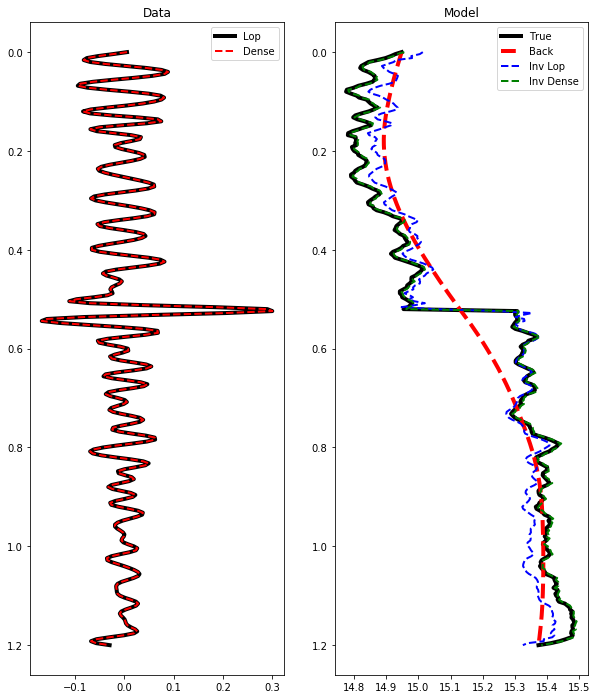

In [18]:
nsmooth = 100
m1dback = filtfilt(np.ones(nsmooth)/float(nsmooth), 1, m1d)

# solve lop
d0 = PPop*m1dback
dr = d - d0
minv = lsqr(PPop, dr, iter_lim=2000)[0]
minv = m1dback + minv

# solve dense
d0_dense = PPop*m1dback
dr_dense = d_dense - d0_dense
minv_dense = lstsq(PPop_dense.A, dr_dense)[0]
minv_dense = m1dback + minv_dense

fig, axs = plt.subplots(1, 2, figsize=(10, 12))
axs[0].plot(d, t0, 'k', lw=4, label='Lop')
axs[0].plot(d_dense, t0,'--r', lw=2, label='Dense')
axs[0].set_title('Data')
axs[0].invert_yaxis()
axs[0].axis('tight')
axs[0].legend()
axs[1].plot(m1d, t0, 'k', lw=4, label='True')
axs[1].plot(m1dback, t0, '--r', lw=4, label='Back')
axs[1].plot(minv, t0, '--b', lw=2, label='Inv Lop')
axs[1].plot(minv_dense, t0, '--g', lw=2, label='Inv Dense')
axs[1].set_title('Model')
axs[1].invert_yaxis()
axs[1].axis('tight')
axs[1].legend();

Dot test passed, v^T(Opu)=-19.617386 - u^T(Op^Tv)=-19.617386
Dot test passed, v^T(Opu)=-5.955516 - u^T(Op^Tv)=-5.955516
Dot test passed, v^T(Opu)=-11.860830 - u^T(Op^Tv)=-11.860830


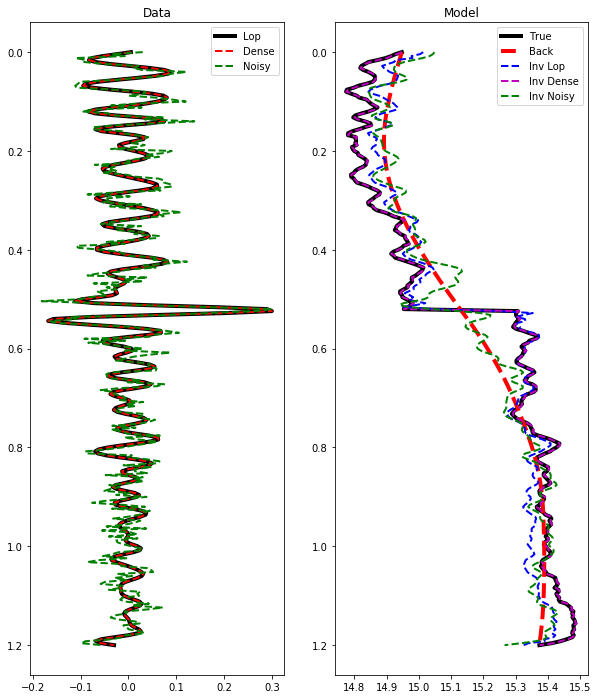

In [19]:
minv_dense = PoststackInversion(d, wav, m0=m1dback, explicit=True, simultaneous=False, dottest=True)[0]

minv = PoststackInversion(d_dense, wav, m0=m1dback, explicit=False, simultaneous=False, dottest=True,
                         **dict(iter_lim=2000))[0]

minv_noise = PoststackInversion(dn_dense, wav, m0=m1dback, explicit=True, 
                                epsR=1e0, dottest=True, **dict(damp=1e-1))[0]


fig, axs = plt.subplots(1, 2, figsize=(10, 12))
axs[0].plot(d, t0, 'k', lw=4, label='Lop')
axs[0].plot(d_dense, t0,'--r', lw=2, label='Dense')
axs[0].plot(dn_dense, t0,'--g', lw=2, label='Noisy')
axs[0].set_title('Data')
axs[0].invert_yaxis()
axs[0].axis('tight')
axs[0].legend()
axs[1].plot(m1d, t0, 'k', lw=4, label='True')
axs[1].plot(m1dback, t0, '--r', lw=4, label='Back')
axs[1].plot(minv, t0, '--b', lw=2, label='Inv Lop')
axs[1].plot(minv_dense, t0, '--m', lw=2, label='Inv Dense')
axs[1].plot(minv_noise, t0, '--g', lw=2, label='Inv Noisy')
axs[1].set_title('Model')
axs[1].invert_yaxis()
axs[1].axis('tight')
axs[1].legend();

## Post-stack inversion - 2D

In [45]:
inputfile='../data/avo/poststack_model.npz'

model = np.load(inputfile)
x, z, m = model['x'], model['z'], np.log(model['model'])
nx, nz = len(x), len(z)

Create operators

In [46]:
# lop
PPop = PoststackLinearModelling(wav, nt0=nz, spatdims=nx)
dottest(PPop, nz*nx, nz*nx, verb=True, tol=1e-3)

# dense
PPop_dense = PoststackLinearModelling(wav, nt0=nz, spatdims=nx, explicit=True)
dottest(PPop, nz*nx, nz*nx, verb=True, tol=1e-3)

# data
d = (PPop*m.flatten()).reshape(nz,nx)
d_dense = (PPop_dense*m.flatten()).reshape(nz,nx)

n = np.random.normal(0, 1e-1, d_dense.shape)
dn = d + n
dn_dense = d_dense + n

Dot test passed, v^T(Opu)=-313.812105 - u^T(Op^Tv)=-313.812105
Dot test passed, v^T(Opu)=-561.247225 - u^T(Op^Tv)=-561.247225


In [47]:
nsmooth = 60
mback = filtfilt(np.ones(nsmooth)/float(nsmooth), 1, m, axis=0)
mback = filtfilt(np.ones(nsmooth)/float(nsmooth), 1, mback, axis=1)

d_0_dense = PPop_dense*mback.flatten()
d_0_lop = PPop*mback.flatten()

Adjoints

In [48]:
madj_dense = PPop_dense.H*d_dense.flatten()
madj = PPop.H*d.flatten()

print((d-d_dense).max())
print((madj-madj_dense).max())

8.049116928532385e-16
8.881784197001252e-16


Different inversion choices with dense operator

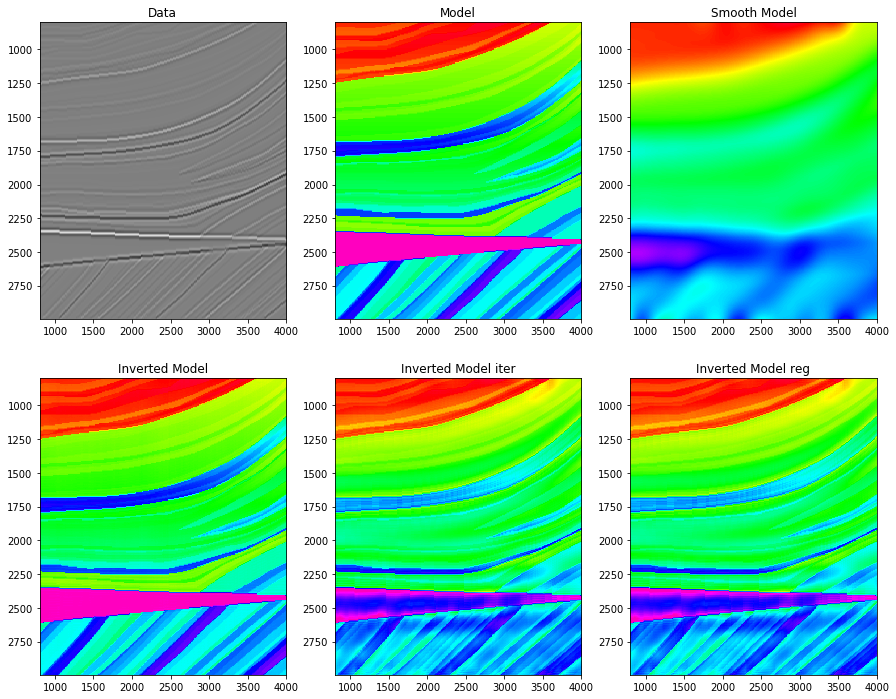

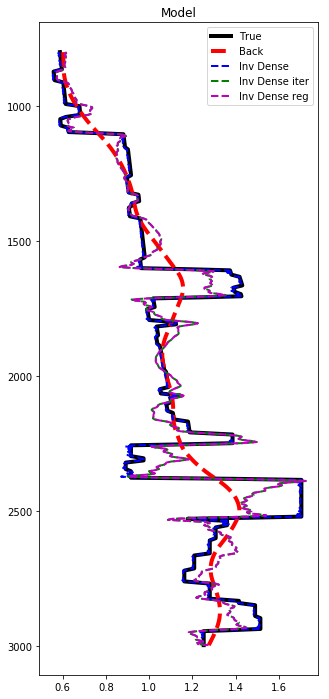

In [49]:
# solve all rows indipendently
d_r_dense = d_dense - d_0_dense.reshape(nz,nx)
minv_dense = lstsq(PPop_dense.A, d_r_dense, cond=1e-6)[0]
minv_dense = mback + minv_dense

# solve all rows together
d_r_dense_iter = d_dense - d_0_dense.reshape(nz,nx)
minv_dense_iter = lsqr(PPop_dense, d_r_dense_iter.flatten(), iter_lim=50)[0]
minv_dense_iter = minv_dense_iter.reshape(nz, nx)
minv_dense_iter = mback + minv_dense_iter.reshape(nz, nx)

# solve all rows together with regularization
D2op  = Laplacian([nz, nx], dtype='float64')

minv_dense_reg = RegularizedInversion(PPop_dense, [D2op], d_r_dense.flatten(),
                                      epsRs=[np.sqrt(1e-4)], returninfo=False,
                                      **dict(damp=np.sqrt(1e-4),
                                             iter_lim=50, show=0))
minv_dense_reg = mback + minv_dense_reg.reshape(nz, nx)


fig, axs = plt.subplots(2, 3, figsize=(15,12))
axs[0][0].imshow(d, cmap='gray', extent = (x[0], x[-1], z[-1], z[0]), vmin=-1, vmax=1)
axs[0][0].set_title('Data')
axs[0][0].axis('tight')
axs[0][1].imshow(m, cmap='gist_rainbow', extent = (x[0], x[-1], z[-1], z[0]),
                 vmin=m.min(), vmax=m.max())
axs[0][1].set_title('Model')
axs[0][1].axis('tight')
axs[0][2].imshow(mback, cmap='gist_rainbow', extent = (x[0], x[-1], z[-1], z[0]),
                 vmin=m.min(), vmax=m.max())
axs[0][2].set_title('Smooth Model')
axs[0][2].axis('tight')
axs[1][0].imshow(minv_dense, cmap='gist_rainbow', extent = (x[0], x[-1], z[-1], z[0]),
                 vmin=m.min(), vmax=m.max())
axs[1][0].set_title('Inverted Model')
axs[1][0].axis('tight')
axs[1][1].imshow(minv_dense_iter, cmap='gist_rainbow', extent = (x[0], x[-1], z[-1], z[0]),
                 vmin=m.min(), vmax=m.max())
axs[1][1].set_title('Inverted Model iter')
axs[1][1].axis('tight');
axs[1][2].imshow(minv_dense_reg, cmap='gist_rainbow', extent = (x[0], x[-1], z[-1], z[0]),
                 vmin=m.min(), vmax=m.max())
axs[1][2].set_title('Inverted Model reg')
axs[1][2].axis('tight');

fig, ax = plt.subplots(1, 1, figsize=(5, 12))
ax.plot(m[:,nx//2], z, 'k', lw=4, label='True')
ax.plot(mback[:,nx//2], z, '--r', lw=4, label='Back')
ax.plot(minv_dense[:,nx//2], z, '--b', lw=2, label='Inv Dense')
ax.plot(minv_dense_iter[:,nx//2], z, '--g', lw=2, label='Inv Dense iter')
ax.plot(minv_dense_reg[:,nx//2], z, '--m', lw=2, label='Inv Dense reg')
ax.set_title('Model')
ax.invert_yaxis()
ax.axis('tight')
ax.legend();

Use function

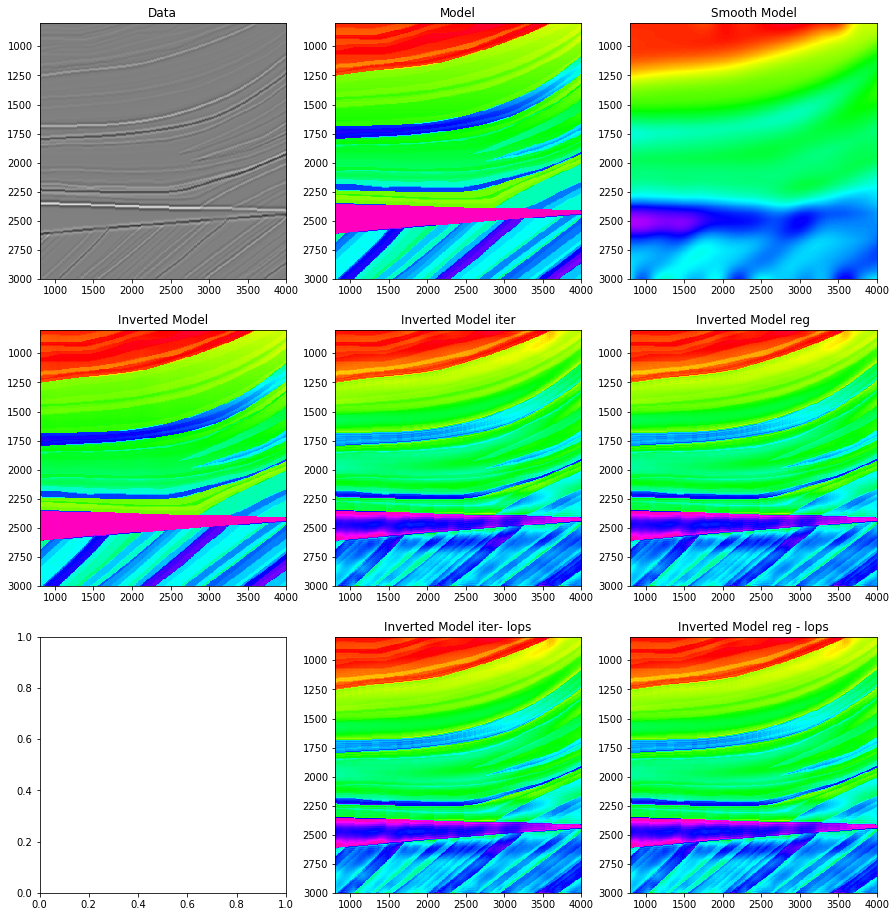

In [50]:
minv_dense_f, dr_dense_f = PoststackInversion(d_dense, wav, m0=mback, explicit=True, simultaneous=False)
minv_dense_iter_f, dr_dense_iter_f = PoststackInversion(d_dense, wav, m0=mback, explicit=True, simultaneous=True, 
                                                        **dict(iter_lim=50))
minv_dense_reg_f, dr_dense_reg_f = PoststackInversion(d_dense, wav, m0=mback, explicit=True, epsR=np.sqrt(1e-4), 
                                                      **dict(damp=np.sqrt(1e-4), iter_lim=50))
minv_lop_iter_f, dr_lop_iter_f = PoststackInversion(d, wav, m0=mback, explicit=False, 
                                                    **dict(iter_lim=50))
minv_lop_reg_f, dr_lop_reg_f = PoststackInversion(d, wav, m0=mback, explicit=False, epsR=np.sqrt(1e-4), 
                                                  **dict(damp=np.sqrt(1e-4), iter_lim=50))


fig, axs = plt.subplots(3, 3, figsize=(15,16))
axs[0][0].imshow(d, cmap='gray', extent = (x[0], x[-1], z[-1], z[0]), vmin=-1, vmax=1)
axs[0][0].set_title('Data')
axs[0][0].axis('tight')
axs[0][1].imshow(m, cmap='gist_rainbow', extent = (x[0], x[-1], z[-1], z[0]),
                 vmin=m.min(), vmax=m.max())
axs[0][1].set_title('Model')
axs[0][1].axis('tight')
axs[0][2].imshow(mback, cmap='gist_rainbow', extent = (x[0], x[-1], z[-1], z[0]),
                 vmin=m.min(), vmax=m.max())
axs[0][2].set_title('Smooth Model')
axs[0][2].axis('tight')
axs[1][0].imshow(minv_dense_f, cmap='gist_rainbow', extent = (x[0], x[-1], z[-1], z[0]),
                 vmin=m.min(), vmax=m.max())
axs[1][0].set_title('Inverted Model')
axs[1][0].axis('tight')
axs[1][1].imshow(minv_dense_iter_f, cmap='gist_rainbow', extent = (x[0], x[-1], z[-1], z[0]),
                 vmin=m.min(), vmax=m.max())
axs[1][1].set_title('Inverted Model iter')
axs[1][1].axis('tight');
axs[1][2].imshow(minv_dense_reg_f, cmap='gist_rainbow', extent = (x[0], x[-1], z[-1], z[0]),
                 vmin=m.min(), vmax=m.max())
axs[1][2].set_title('Inverted Model reg')
axs[1][2].axis('tight');
axs[2][1].imshow(minv_lop_iter_f, cmap='gist_rainbow', extent = (x[0], x[-1], z[-1], z[0]),
                 vmin=m.min(), vmax=m.max())
axs[2][1].set_title('Inverted Model iter- lops')
axs[2][1].axis('tight');
axs[2][2].imshow(minv_lop_reg_f, cmap='gist_rainbow', extent = (x[0], x[-1], z[-1], z[0]),
                 vmin=m.min(), vmax=m.max())
axs[2][2].set_title('Inverted Model reg - lops')
axs[2][2].axis('tight');

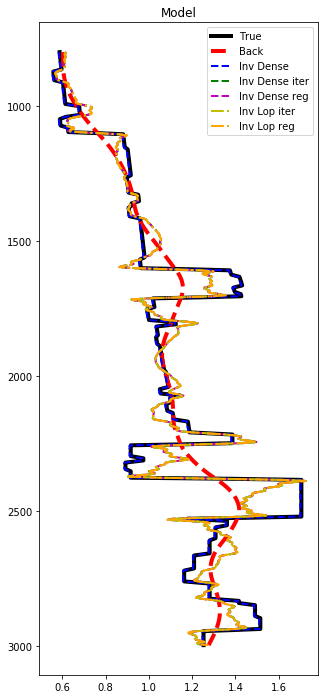

In [51]:
fig, ax = plt.subplots(1, 1, figsize=(5, 12))
ax.plot(m[:,nx//2], z, 'k', lw=4, label='True')
ax.plot(mback[:,nx//2], z, '--r', lw=4, label='Back')
ax.plot(minv_dense_f[:,nx//2], z, '--b', lw=2, label='Inv Dense')
ax.plot(minv_dense_iter_f[:,nx//2], z, '--g', lw=2, label='Inv Dense iter')
ax.plot(minv_dense_reg_f[:,nx//2], z, '--m', lw=2, label='Inv Dense reg')
ax.plot(minv_lop_iter_f[:,nx//2], z, '-.y', lw=2, label='Inv Lop iter')
ax.plot(minv_lop_reg_f[:,nx//2], z, 'orange', ls='-.', lw=2, label='Inv Lop reg')
ax.set_title('Model')
ax.invert_yaxis()
ax.axis('tight')
ax.legend();

Repeat the same with noisy data

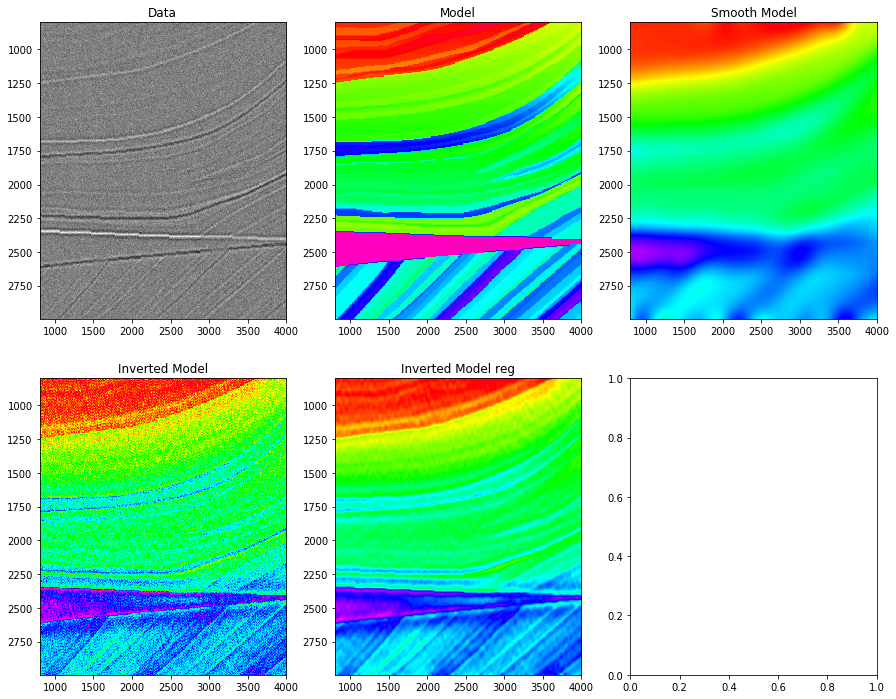

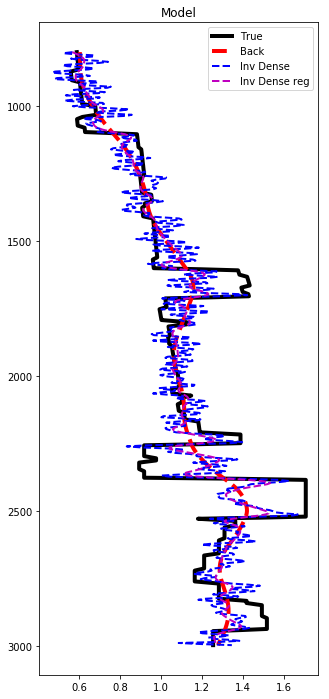

In [54]:
# solve all rows indipendently
#d_r_dense = dn_dense - d_0_dense.reshape(nz,nx)
#minv_dense = lstsq(PPop_dense.A, d_r_dense, cond=1e0)[0]
#minv_dense = mback + minv_dense
d_r_dense = dn_dense - d_0_dense.reshape(nz,nx)
minv_dense = lstsq(np.dot(PPop_dense.A.T, PPop_dense.A) + 1e-1*np.eye(nz), 
                   np.dot(PPop_dense.A.T, d_r_dense))[0]
minv_dense = mback + minv_dense

# solve all rows together with regularization
D2op  = Laplacian([nz, nx], dtype='float64')

minv_dense_reg = RegularizedInversion(PPop_dense, [D2op], dn_dense.flatten(),
                                      x0 = minv_dense.flatten(),
                                      epsRs=[np.sqrt(1e2)], returninfo=False,
                                      **dict(damp=np.sqrt(1e-2),
                                             iter_lim=50, show=0))
minv_dense_reg = minv_dense_reg.reshape(nz, nx)

fig, axs = plt.subplots(2, 3, figsize=(15,12))
axs[0][0].imshow(dn, cmap='gray', extent = (x[0], x[-1], z[-1], z[0]), vmin=-1, vmax=1)
axs[0][0].set_title('Data')
axs[0][0].axis('tight')
axs[0][1].imshow(m, cmap='gist_rainbow', extent = (x[0], x[-1], z[-1], z[0]), 
                 vmin=m.min(), vmax=m.max())
axs[0][1].set_title('Model')
axs[0][1].axis('tight')
axs[0][2].imshow(mback, cmap='gist_rainbow', extent = (x[0], x[-1], z[-1], z[0]), 
                 vmin=m.min(), vmax=m.max())
axs[0][2].set_title('Smooth Model')
axs[0][2].axis('tight')
axs[1][0].imshow(minv_dense, cmap='gist_rainbow', extent = (x[0], x[-1], z[-1], z[0]), 
                 vmin=m.min(), vmax=m.max())
axs[1][0].set_title('Inverted Model')
axs[1][0].axis('tight')
axs[1][1].imshow(minv_dense_reg, cmap='gist_rainbow', extent = (x[0], x[-1], z[-1], z[0]), 
                 vmin=m.min(), vmax=m.max())
axs[1][1].set_title('Inverted Model reg')
axs[1][1].axis('tight')

fig, ax = plt.subplots(1, 1, figsize=(5, 12))
ax.plot(m[:,nx//2], z, 'k', lw=4, label='True')
ax.plot(mback[:,nx//2], z, '--r', lw=4, label='Back')
ax.plot(minv_dense[:,nx//2], z, '--b', lw=2, label='Inv Dense')
ax.plot(minv_dense_reg[:,nx//2], z, '--m', lw=2, label='Inv Dense reg')
ax.set_title('Model')
ax.invert_yaxis()
ax.axis('tight')
ax.legend();

Use function

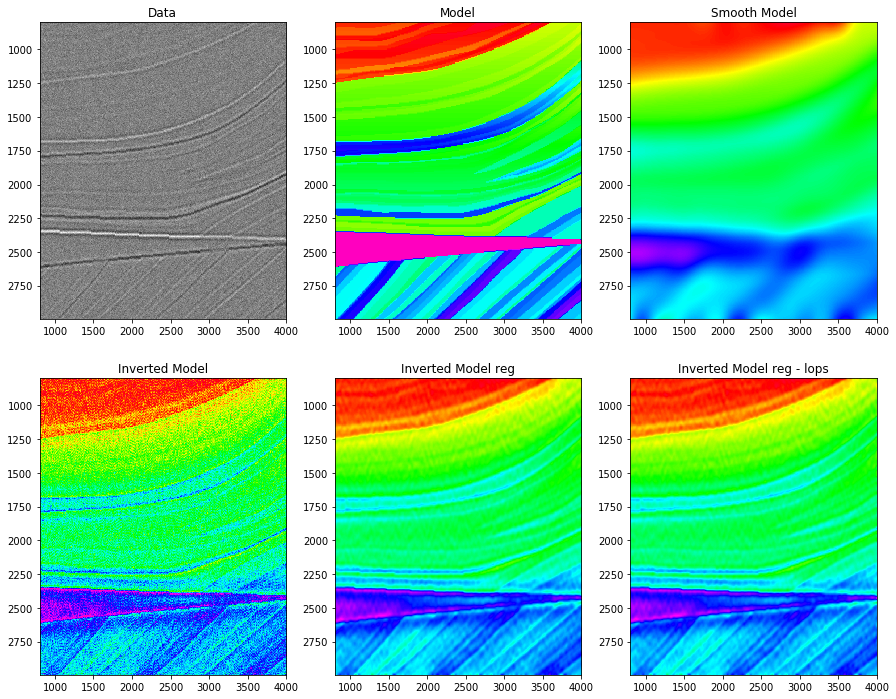

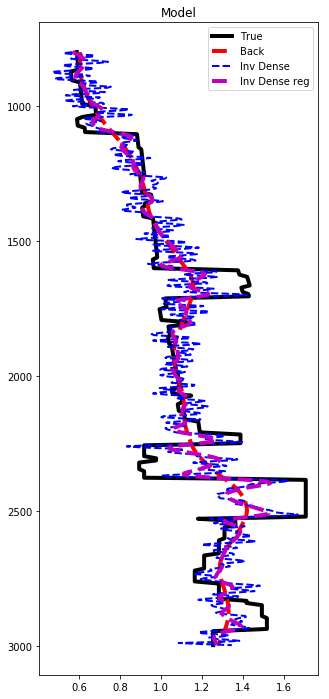

In [56]:
minv_dense_f, dr_dense_f = PoststackInversion(dn, wav, m0=mback, explicit=True, epsI=1e-1, 
                                              simultaneous=False)
minv_dense_reg_f, dr_dense_reg_f = PoststackInversion(dn, wav, m0=minv_dense_f, explicit=True, 
                                                      epsR=np.sqrt(1e2), 
                                                      **dict(damp=np.sqrt(1e-2), iter_lim=50))
minv_lop_reg_f, dr_lop_reg_f = PoststackInversion(dn, wav, m0=minv_dense_f, explicit=False, 
                                                  epsR=np.sqrt(1e2), 
                                                  **dict(damp=np.sqrt(1e-2), iter_lim=50))

fig, axs = plt.subplots(2, 3, figsize=(15,12))
axs[0][0].imshow(dn, cmap='gray', extent = (x[0], x[-1], z[-1], z[0]), vmin=-1, vmax=1)
axs[0][0].set_title('Data')
axs[0][0].axis('tight')
axs[0][1].imshow(m, cmap='gist_rainbow', extent = (x[0], x[-1], z[-1], z[0]), 
                 vmin=m.min(), vmax=m.max())
axs[0][1].set_title('Model')
axs[0][1].axis('tight')
axs[0][2].imshow(mback, cmap='gist_rainbow', extent = (x[0], x[-1], z[-1], z[0]), 
                 vmin=m.min(), vmax=m.max())
axs[0][2].set_title('Smooth Model')
axs[0][2].axis('tight')
axs[1][0].imshow(minv_dense_f, cmap='gist_rainbow', extent = (x[0], x[-1], z[-1], z[0]), 
                 vmin=m.min(), vmax=m.max())
axs[1][0].set_title('Inverted Model')
axs[1][0].axis('tight')
axs[1][1].imshow(minv_dense_reg_f, cmap='gist_rainbow', extent = (x[0], x[-1], z[-1], z[0]), 
                 vmin=m.min(), vmax=m.max())
axs[1][1].set_title('Inverted Model reg')
axs[1][1].axis('tight');
axs[1][2].imshow(minv_lop_reg_f, cmap='gist_rainbow', extent = (x[0], x[-1], z[-1], z[0]), 
                 vmin=m.min(), vmax=m.max())
axs[1][2].set_title('Inverted Model reg - lops')
axs[1][2].axis('tight');

fig, ax = plt.subplots(1, 1, figsize=(5, 12))
ax.plot(m[:,nx//2], z, 'k', lw=4, label='True')
ax.plot(mback[:,nx//2], z, '--r', lw=4, label='Back')
ax.plot(minv_dense[:,nx//2], z, '--b', lw=2, label='Inv Dense')
ax.plot(minv_dense_reg[:,nx//2], z, '--m', lw=4, label='Inv Dense reg')
ax.set_title('Model')
ax.invert_yaxis()
ax.axis('tight')
ax.legend();

## Post-stack inversion - 3D

In [30]:
ny = 30

m3d = np.tile(m[:, :, np.newaxis], (1, 1, ny))
mback3d = np.tile(mback[:, :, np.newaxis], (1, 1, ny))

y = np.arange(ny)
x, z, m = model['x'], model['z'], np.log(model['model'])
ny, nx, nz = len(y), len(x), len(z)

In [31]:
# lop
PPop = PoststackLinearModelling(wav, nt0=nz, spatdims=(nx, ny))
dottest(PPop, nz*nx*ny, nz*nx*ny, verb=True, tol=1e-3)

# dense
PPop_dense = PoststackLinearModelling(wav, nt0=nz, spatdims=(nx, ny), explicit=True)
dottest(PPop, nz*nx*ny, nz*nx*ny, verb=True, tol=1e-3)

# data
d = (PPop*m3d.flatten()).reshape(nz, nx, ny)
d_dense = (PPop_dense*m3d.flatten()).reshape(nz, nx, ny)

n = np.random.normal(0, 1e-2, d_dense.shape)
dn = d + n
dn_dense = d_dense + n

Dot test passed, v^T(Opu)=-1944.587464 - u^T(Op^Tv)=-1944.587464
Dot test passed, v^T(Opu)=-1103.798364 - u^T(Op^Tv)=-1103.798364


(800.0, 3996.0, 2996.0, 800.0)

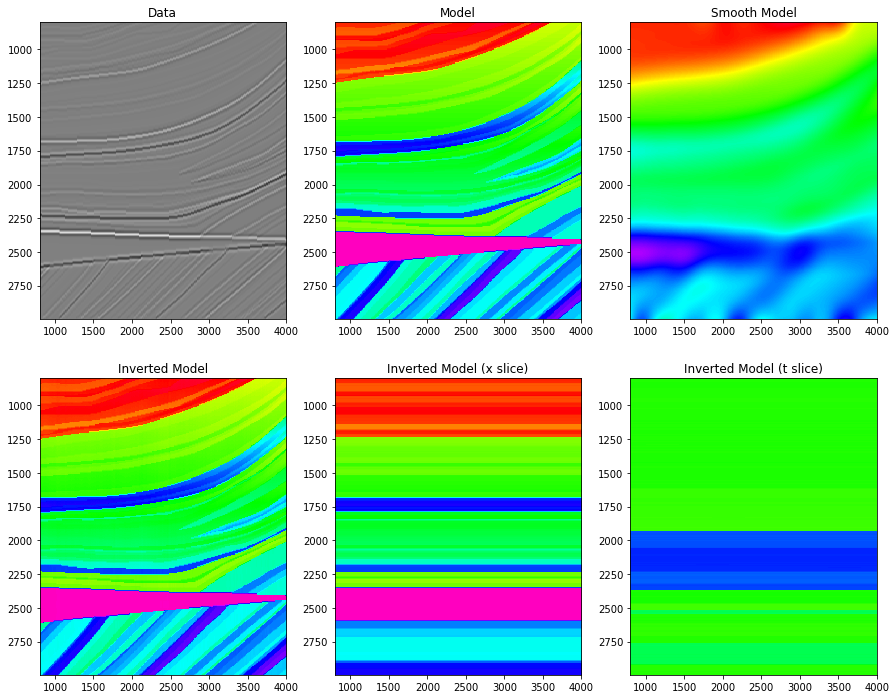

In [32]:
minv_dense_f, dr_dense_f = PoststackInversion(d_dense, wav, m0=mback3d, explicit=True,
                                              simultaneous=False)

fig, axs = plt.subplots(2, 3, figsize=(15,12))
axs[0][0].imshow(d_dense[:, :, 5], cmap='gray', extent = (x[0], x[-1], z[-1], z[0]), vmin=-1, vmax=1)
axs[0][0].set_title('Data')
axs[0][0].axis('tight')
axs[0][1].imshow(m3d[:, :, 5], cmap='gist_rainbow', extent = (x[0], x[-1], z[-1], z[0]), 
                 vmin=m.min(), vmax=m.max())
axs[0][1].set_title('Model')
axs[0][1].axis('tight')
axs[0][2].imshow(mback3d[:, :, 5], cmap='gist_rainbow', extent = (x[0], x[-1], z[-1], z[0]), 
                 vmin=m.min(), vmax=m.max())
axs[0][2].set_title('Smooth Model')
axs[0][2].axis('tight')
axs[1][0].imshow(minv_dense_f[:, :, 5], cmap='gist_rainbow', extent = (x[0], x[-1], z[-1], z[0]), 
                 vmin=m.min(), vmax=m.max())
axs[1][0].set_title('Inverted Model')
axs[1][0].axis('tight')
axs[1][1].imshow(minv_dense_f[:, 50], cmap='gist_rainbow', extent = (x[0], x[-1], z[-1], z[0]), 
                 vmin=m.min(), vmax=m.max())
axs[1][1].set_title('Inverted Model (x slice)')
axs[1][1].axis('tight')
axs[1][2].imshow(minv_dense_f[200], cmap='gist_rainbow', extent = (x[0], x[-1], z[-1], z[0]), 
                 vmin=m.min(), vmax=m.max())
axs[1][2].set_title('Inverted Model (t slice)')
axs[1][2].axis('tight')

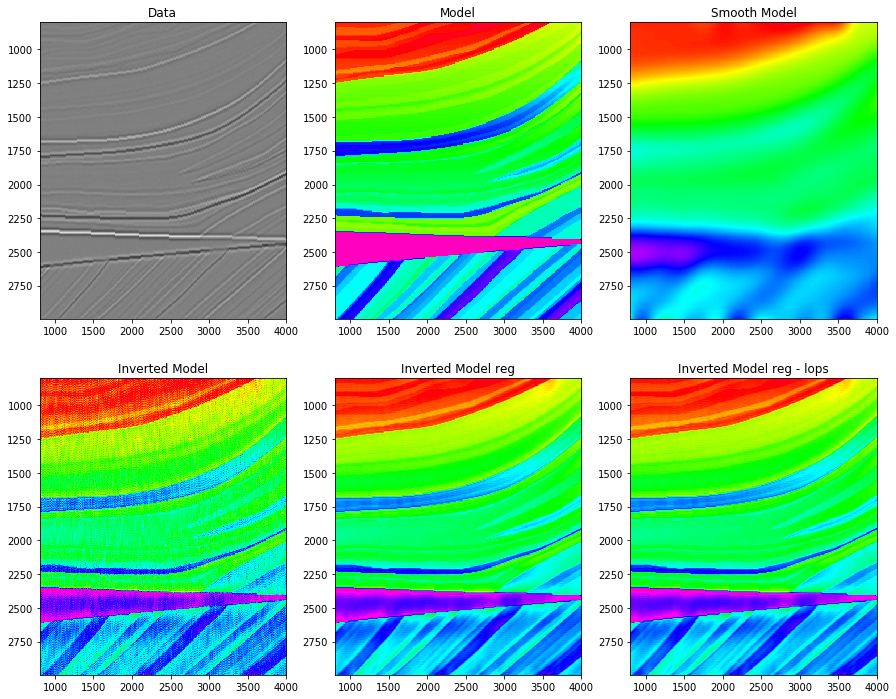

In [33]:
minv_dense_f, dr_dense_f = PoststackInversion(dn_dense, wav, m0=mback3d, explicit=True, epsI=1e-3, 
                                              simultaneous=False)

minv_dense_reg_f, dr_dense_reg_f = PoststackInversion(dn_dense, wav, m0=minv_dense_f, explicit=True, 
                                                      epsR=np.sqrt(1e2), 
                                                      **dict(damp=np.sqrt(1e-2), iter_lim=50))
minv_lop_reg_f, dr_lop_reg_f = PoststackInversion(dn, wav, m0=minv_dense_f, explicit=False, 
                                                  epsR=np.sqrt(1e2), 
                                                  **dict(damp=np.sqrt(1e-2), iter_lim=50))

fig, axs = plt.subplots(2, 3, figsize=(15,12))
axs[0][0].imshow(dn[:, :, 5], cmap='gray', extent = (x[0], x[-1], z[-1], z[0]), vmin=-1, vmax=1)
axs[0][0].set_title('Data')
axs[0][0].axis('tight')
axs[0][1].imshow(m3d[:, :, 5], cmap='gist_rainbow', extent = (x[0], x[-1], z[-1], z[0]), 
                 vmin=m.min(), vmax=m.max())
axs[0][1].set_title('Model')
axs[0][1].axis('tight')
axs[0][2].imshow(mback3d[:, :, 5], cmap='gist_rainbow', extent = (x[0], x[-1], z[-1], z[0]), 
                 vmin=m.min(), vmax=m.max())
axs[0][2].set_title('Smooth Model')
axs[0][2].axis('tight')
axs[1][0].imshow(minv_dense_f[:, :, 5], cmap='gist_rainbow', extent = (x[0], x[-1], z[-1], z[0]), 
                 vmin=m.min(), vmax=m.max())
axs[1][0].set_title('Inverted Model')
axs[1][0].axis('tight')
axs[1][1].imshow(minv_dense_reg_f[:, :, 5], cmap='gist_rainbow', extent = (x[0], x[-1], z[-1], z[0]), 
                 vmin=m.min(), vmax=m.max())
axs[1][1].set_title('Inverted Model reg')
axs[1][1].axis('tight');
axs[1][2].imshow(minv_lop_reg_f[:, :, 5], cmap='gist_rainbow', extent = (x[0], x[-1], z[-1], z[0]), 
                 vmin=m.min(), vmax=m.max())
axs[1][2].set_title('Inverted Model reg - lops')
axs[1][2].axis('tight');

## Pre-stack inversion - 2D

In [34]:
inputfile='../data/avo/poststack_model.npz'

model = np.load(inputfile)
x, z, m = model['x'][::3], model['z'], 1000*model['model'][:, ::3]
nx, nz = len(x), len(z)

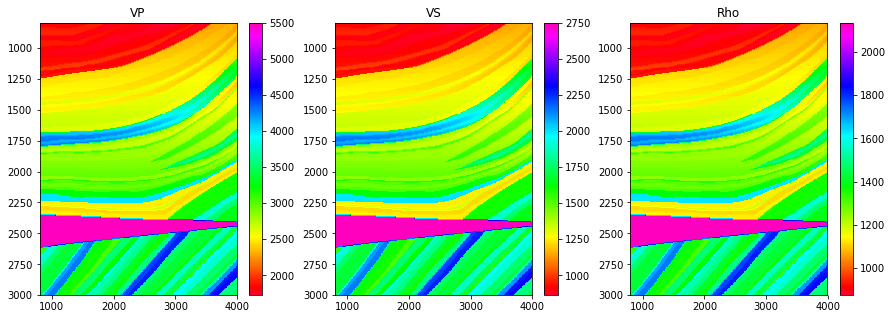

In [35]:
mvp = m.copy()
mvs = m/2
mrho = m/3+300

fig, axs = plt.subplots(1, 3, figsize=(15,5))
im=axs[0].imshow(mvp, cmap='gist_rainbow', extent = (x[0], x[-1], z[-1], z[0]), 
              vmin=mvp.min(), vmax=mvp.max())
axs[0].set_title('VP')
axs[0].axis('tight')
plt.colorbar(im, ax=axs[0])
im=axs[1].imshow(mvs, cmap='gist_rainbow', extent = (x[0], x[-1], z[-1], z[0]),
              vmin=mvs.min(), vmax=mvs.max())
axs[1].set_title('VS')
plt.colorbar(im, ax=axs[1])
axs[1].axis('tight')
im=axs[2].imshow(mrho, cmap='gist_rainbow', extent = (x[0], x[-1], z[-1], z[0]),
              vmin=mrho.min(), vmax=mrho.max())
axs[2].set_title('Rho')
axs[2].axis('tight');
plt.colorbar(im, ax=axs[2])

In [36]:
m = np.log(np.stack((mvp, mvs, mrho),axis=1))

# lop (constant vsvp)
PPop = PrestackLinearModelling(wav, theta, vsvp=vsvp, nt0=nz, 
                               spatdims=(nx,), linearization='akirich')
dottest(PPop, nz*ntheta*nx, nz*3*nx, verb=True)

# dense (constant vsvp)
PPop_dense = PrestackLinearModelling(wav, theta, vsvp=vsvp, nt0=nz, 
                                     spatdims=(nx,), linearization='akirich', explicit=True)
dottest(PPop_dense, nz*ntheta*nx, nz*3*nx, verb=True);

# lop
dPP = PPop*m.flatten()
dPP = dPP.reshape(nz,ntheta,nx)

# dense
dPP_dense = PPop_dense*m.swapaxes(0,1).flatten()
dPP_dense = dPP_dense.reshape(ntheta,nz,nx).swapaxes(0,1)
dPPn_dense = dPP_dense + np.random.normal(0, 5e-2, dPP_dense.shape)

Dot test passed, v^T(Opu)=1678.529598 - u^T(Op^Tv)=1678.529598
Dot test passed, v^T(Opu)=564.265345 - u^T(Op^Tv)=564.265345


In [37]:
madj_dense = PPop_dense.H*(dPP_dense.swapaxes(0,1).flatten())
madj = PPop.H*dPP.flatten()

madj_dense = madj_dense.reshape(3,nz,nx).swapaxes(0,1)
madj = madj.reshape(nz,3,nx)

print((dPP-dPP_dense).max())
print((madj-madj_dense).max())

4.505076867111768e-15
9.769962616701378e-15


(-0.5, 20.5, 549.5, -0.5)

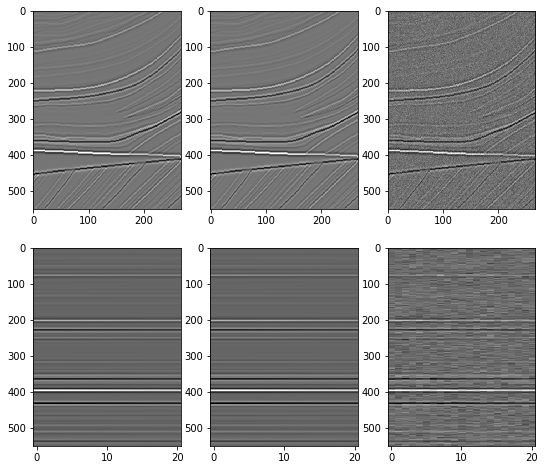

In [38]:
fig, axs = plt.subplots(2, 3, figsize=(9,8))
axs[0][0].imshow(dPP[:,0,:], cmap='gray')
axs[0][0].axis('tight')
axs[0][1].imshow(dPP_dense[:,0,:], cmap='gray')
axs[0][1].axis('tight')
axs[0][2].imshow(dPPn_dense[:,0,:], cmap='gray')
axs[0][2].axis('tight')
axs[1][0].imshow(dPP[:,:,nx//2], cmap='gray')
axs[1][0].axis('tight')
axs[1][1].imshow(dPP_dense[:,:,nx//2], cmap='gray')
axs[1][1].axis('tight')
axs[1][2].imshow(dPPn_dense[:,:,nx//2], cmap='gray')
axs[1][2].axis('tight')

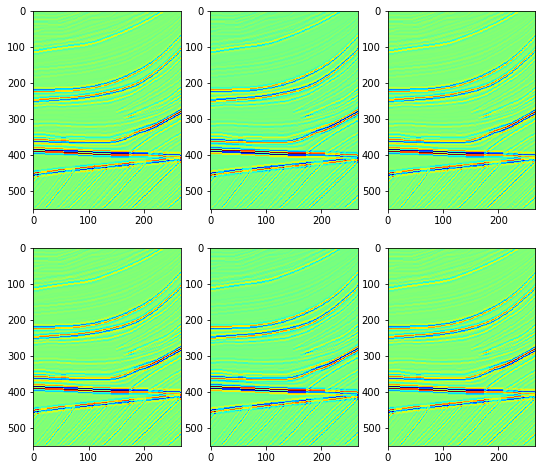

In [39]:
fig, axs = plt.subplots(2, 3, figsize=(9,8))
axs[0][0].imshow(madj[:,0,:], cmap='jet')
axs[0][0].axis('tight')
axs[0][1].imshow(madj[:,1,:], cmap='jet')
axs[0][1].axis('tight')
axs[0][2].imshow(madj[:,2,:], cmap='jet')
axs[0][2].axis('tight')
axs[1][0].imshow(madj_dense[:,0,:], cmap='jet')
axs[1][0].axis('tight')
axs[1][1].imshow(madj_dense[:,1,:], cmap='jet')
axs[1][1].axis('tight')
axs[1][2].imshow(madj_dense[:,2,:], cmap='jet')
axs[1][2].axis('tight');

In [40]:
def plotinversion(m, mback, minv, params = ['VP', 'VS', 'Rho'], title=None):
    fig, axs = plt.subplots(3, 3, figsize=(15,12))
    fig.suptitle(title)
    for ip, param in enumerate(params):
        im=axs[0][ip].imshow(m[:,ip], cmap='gist_rainbow', extent = (x[0], x[-1], z[-1], z[0]), 
                  vmin=m[:,ip].min(), vmax=m[:,ip].max())
        axs[0][ip].set_title(param+' - true')
        axs[0][ip].axis('tight')
        plt.colorbar(im, ax=axs[0][ip])

        im=axs[1][ip].imshow(mback[:,ip], cmap='gist_rainbow', extent = (x[0], x[-1], z[-1], z[0]), 
                             vmin=m[:,ip].min(), vmax=m[:,ip].max())
        axs[1][ip].set_title(param+' - back')
        axs[1][ip].axis('tight')
        plt.colorbar(im, ax=axs[1][ip])
        im=axs[2][ip].imshow(minv[:,ip], cmap='gist_rainbow', extent = (x[0], x[-1], z[-1], z[0]), 
                             vmin=m[:,ip].min(), vmax=m[:,ip].max())
        axs[2][ip].set_title(param+' - inv')
        axs[2][ip].axis('tight')
        plt.colorbar(im, ax=axs[2][ip])

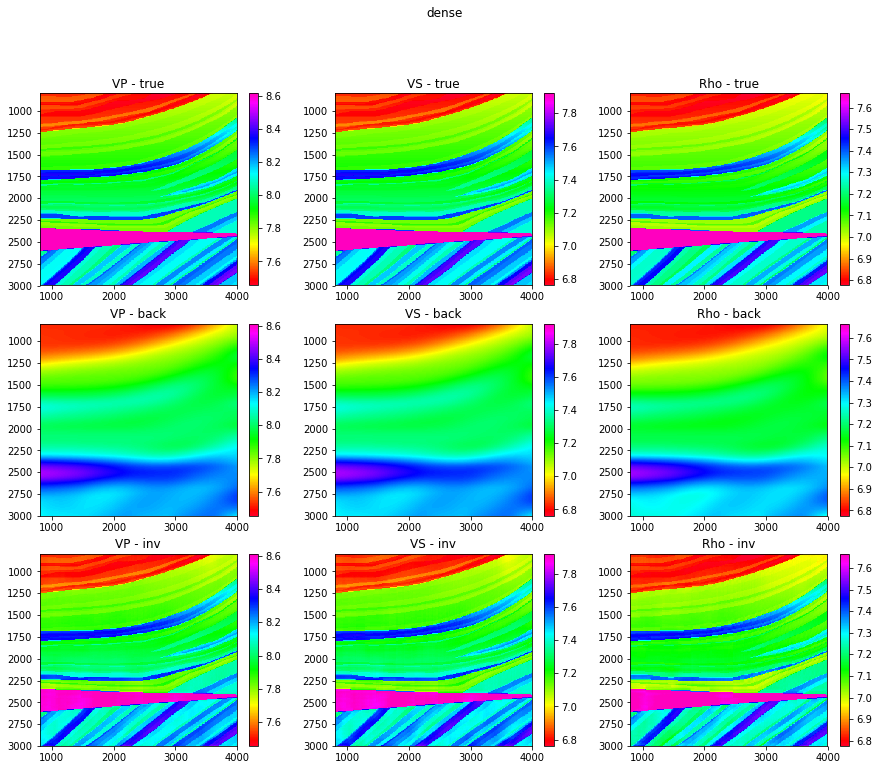

In [41]:
mback = filtfilt(np.ones(nsmooth)/float(nsmooth), 1, m, axis=0)
mback = filtfilt(np.ones(nsmooth)/float(nsmooth), 1, mback, axis=2)

minv_dense, dPP_dense_res = \
    PrestackInversion(dPP_dense, theta, wav, m0=mback, linearization='akirich',
                      explicit=True, simultaneous=False, dottest=False, 
                      returnres=True, **dict(cond=1e-5))

plotinversion(m, mback, minv_dense, params = ['VP', 'VS', 'Rho'], title='dense')

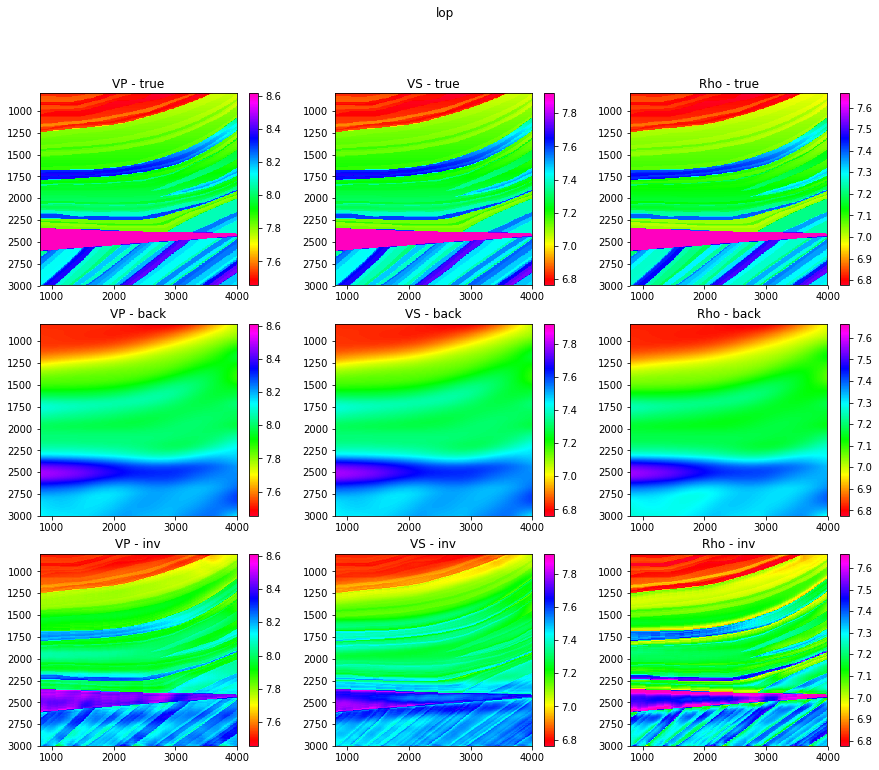

In [42]:
minv_lop = \
    PrestackInversion(dPP, theta, wav, m0=mback, linearization='akirich',
                      explicit=False, dottest=False, 
                      returnres=False, **dict(iter_lim=100))

plotinversion(m, mback, minv_lop, params = ['VP', 'VS', 'Rho'], title='lop')

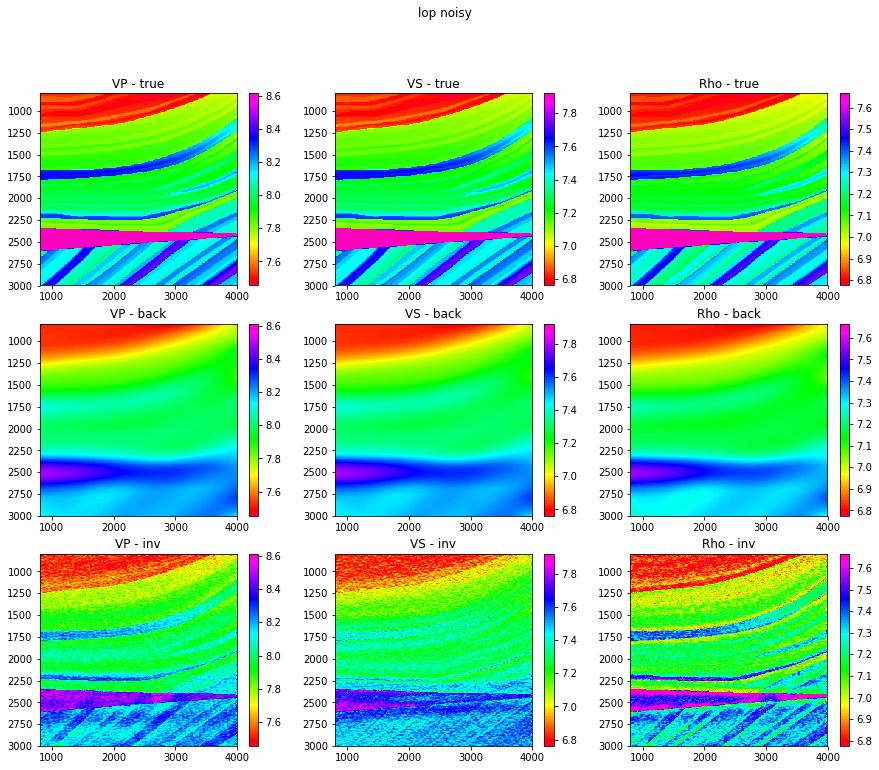

In [43]:
minv_lop_n = \
    PrestackInversion(dPPn_dense, theta, wav, m0=mback, 
                      explicit=False, simultaneous=True, dottest=False, epsR=1e-1,
                      returnres=False, **dict(iter_lim=100))

plotinversion(m, mback, minv_lop_n, params = ['VP', 'VS', 'Rho'], title='lop noisy')

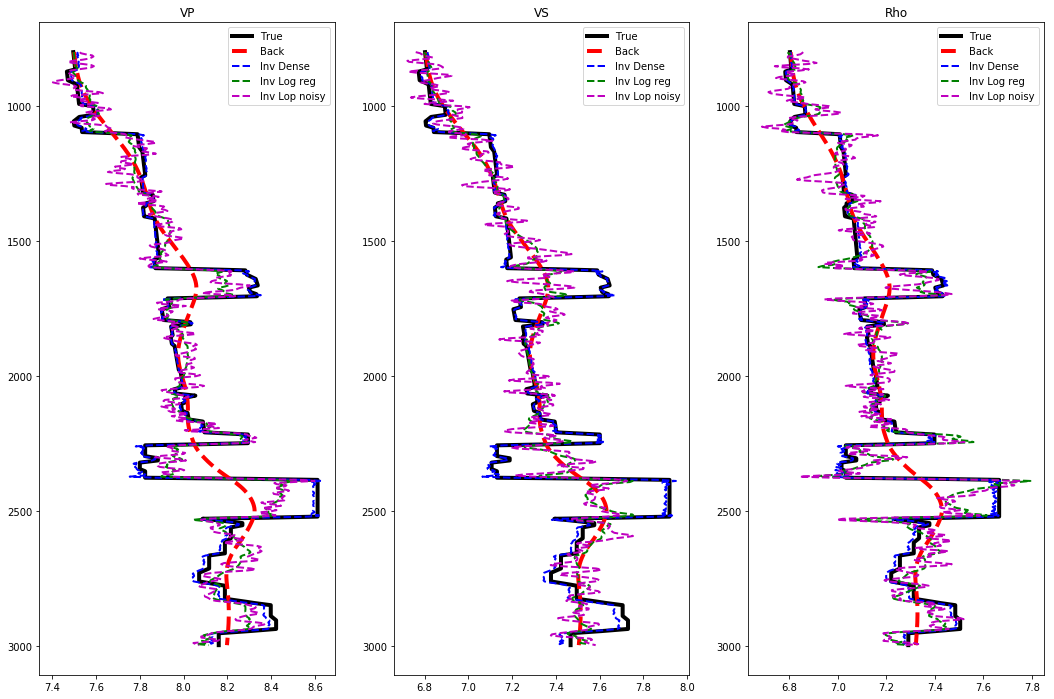

In [44]:
params = ['VP', 'VS', 'Rho']
fig, axs = plt.subplots(1, 3, figsize=(18, 12))
for ip, param in enumerate(params):
    axs[ip].plot(m[:, ip, nx//2], z, 'k', lw=4, label='True')
    axs[ip].plot(mback[:, ip, nx//2], z, '--r', lw=4, label='Back')
    axs[ip].plot(minv_dense[:, ip, nx//2], z, '--b', lw=2, label='Inv Dense')
    axs[ip].plot(minv_lop[:, ip, nx//2], z, '--g', lw=2, label='Inv Log reg')
    axs[ip].plot(minv_lop_n[:, ip, nx//2], z, '--m', lw=2, label='Inv Lop noisy')
    axs[ip].set_title(param)
    axs[ip].invert_yaxis()
    axs[ip].legend()